- https://youtu.be/Q_MbN-vu_2w?si=TrCYKV6q64rN6-Fq
- https://youtu.be/qBs29egdVNU?si=9X_UuFSqqsLBNndo
- https://youtu.be/cZ5w3b9ES7Q?si=NaiWh-SkPjqmKlmS

# [자전거 공유 수요](https://www.kaggle.com/competitions/bike-sharing-demand/overview)
워싱턴D.C 소재의 자전거 대여 스타트업의 데이터를 활용하여, 특정 시간대에 얼마나 많은 사람들이 자전거를 대여하는지 예측하는 것이 목표!!

## 평가지표 - RMSLE
- Root Mean Squared Logarithmic Error
- 잔차(residual)에 대한 평균에 로그를 씌운 값
- 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해
- 정답에 대한 오류를 숫자로 나타낸 값이 클 수록 오차가 크다는 의미이다.
  - 즉, 값이 작을 수록 오류가 적다는 의미를 나타낸다.

$$ RMSLE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(y_{i}+1)-log(y\hat{}_{i}+1))^2}$$

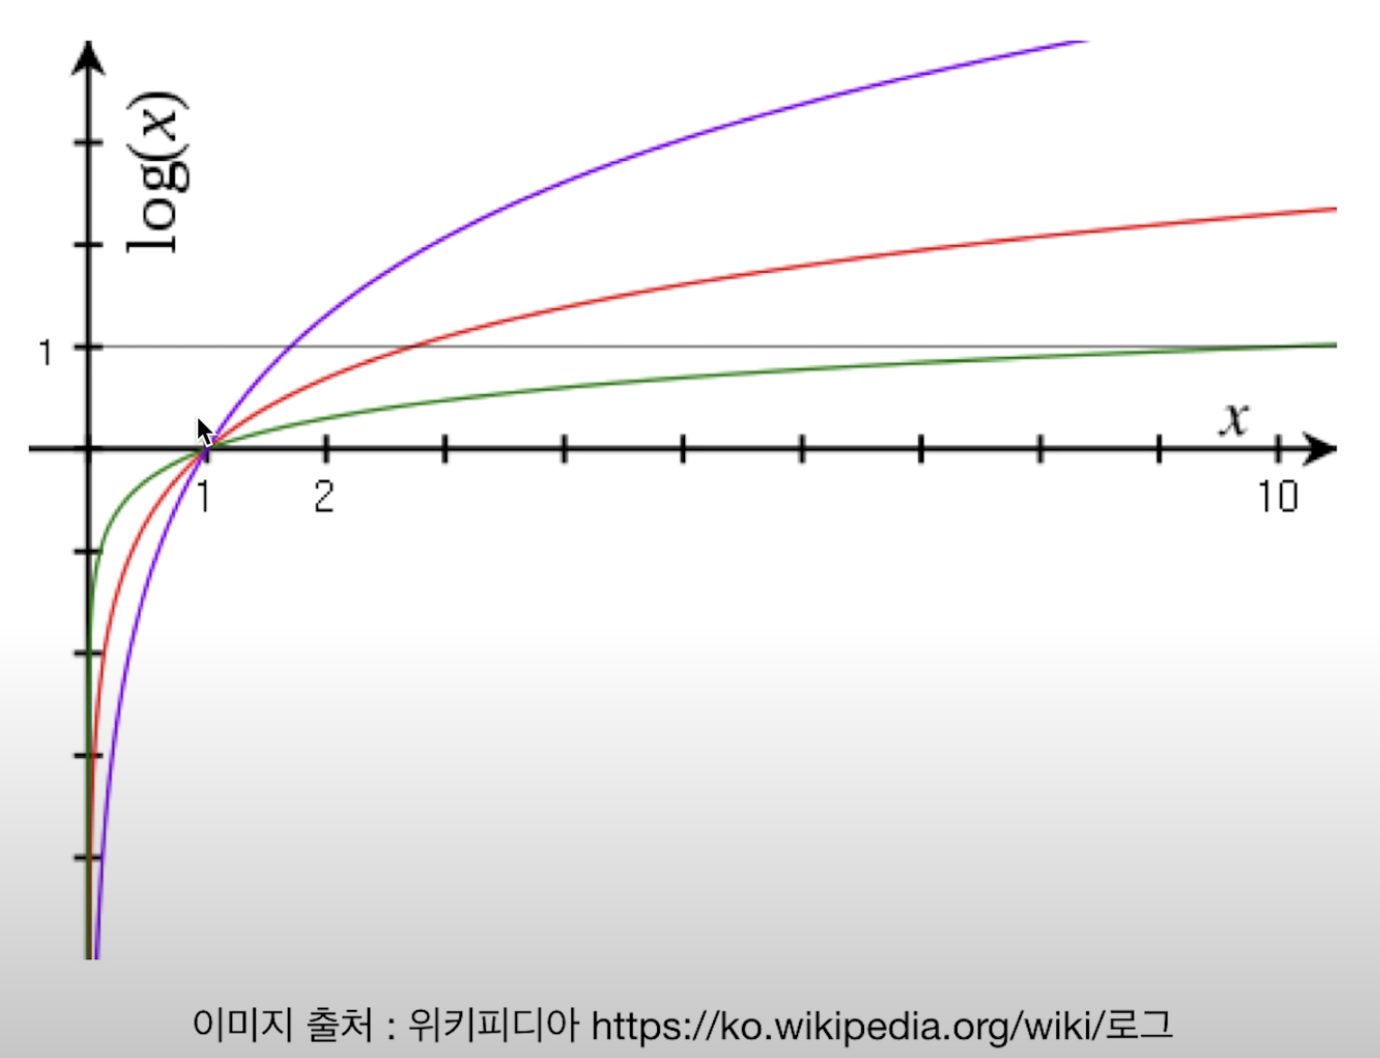

In [1]:
import numpy as np

def rmsle(y, pred, convertExp=False):
    if convertExp:
        y = np.exp(y)
        pred = np.exp(pred)

    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in pred]))
    calc = (log1 - log2)**2

    return np.sqrt(np.mean(calc))

In [2]:
from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## [Data 설명](https://www.kaggle.com/competitions/bike-sharing-demand/data?select=sampleSubmission.csv)

### Features

- datetime:  
  - hourly date + timestamp  
- season(계절):  
  - 1 = spring
  - 2 = summer
  - 3 = fall
  - 4 = winter
- holiday(휴일):  
  - whether the day is considered a holiday
- workingday(근무일):
  - whether the day is neither a weekend nor holiday
- weather(날씨):
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp(온도):
  - temperature in Celsius
- atemp(체감온도):
  - "feels like" temperature in Celsius
- humidity(습도):
  - relative humidity
- windspeed(풍속):
  - wind speed

### Target

- count:
  - 총 대여 수
  - number of total rentals

참고용
- casual:
  - 미등록 사용자 대여 개시 수
  - number of non-registered user rentals initiated
- registered:
  - 등록 사용자 대여 개시
  -  number of registered user rentals initiated

# Import Library

In [3]:
import os
import datetime

# 데이터 분석
import numpy as np
import pandas as pd
from scipy import stats

# 데이터 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')



# 데이터 분리
from sklearn.model_selection import train_test_split


# warning
import warnings
warnings.filterwarnings('ignore')

## Connect to google account

In [4]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


# Global Variables

In [5]:
import easydict
import json
args = easydict.EasyDict()

# path
args.default_path = '/content/data/MyDrive/google_lecture/05. machine learning/Projects/kaggle/bike_sharing_demand/data/'
args.train_path = args.default_path+'train.csv'
args.test_path = args.default_path+'test.csv'

args.submission_path = args.default_path+'sampleSubmission.csv'
args.submission_file = 'Submission_HPOModel_{0:.5f}.csv'

args.SEED = 42
args.target_col = 'count'

In [6]:
import random
import numpy as np

def reset_seeds(seed=args.SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)

reset_seeds()

# Load Data

## train data

In [7]:
ori_train = pd.read_csv(args.train_path)

print(ori_train.shape)
ori_train.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


### target

In [8]:
ori_train['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

## test data

In [9]:
ori_test = pd.read_csv(args.test_path)

print(ori_test.shape)
ori_test.head(3)

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


## 결측치 확인

In [10]:
ori_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [11]:
ori_test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

## 데이터 타입 확인

In [12]:
ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [13]:
ori_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### 데이터 타입 변경

In [14]:
ori_train['datetime'] = pd.to_datetime(ori_train['datetime'])
ori_test['datetime'] = pd.to_datetime(ori_test['datetime'])

In [15]:
ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


## datetime 변수 생성

In [16]:
print(f'before: {ori_train.shape} / {ori_test.shape}')

for data in [ori_train, ori_test]:
  data['year'] = data['datetime'].dt.year # 년도
  data['month'] = data['datetime'].dt.month # 월
  data['day'] = data['datetime'].dt.day # 일
  data['dayofweek'] = data['datetime'].dt.dayofweek # 요일
  data['quarter'] = data['datetime'].dt.quarter # 분기
  data['hour'] = data['datetime'].dt.hour # 시간
  data['minute'] = data['datetime'].dt.minute # 분
  data['second'] = data['datetime'].dt.second # 초

  data['weekend'] = data['dayofweek'].apply(lambda x: int(x in [5,6]))

print(f'after: {ori_train.shape} / {ori_test.shape}')

before: (10886, 12) / (6493, 9)
after: (10886, 21) / (6493, 18)


## 필요없는 컬럼 제거

- test에 없는 컬럼 제외

In [17]:
drop_cols = list(set(ori_train.columns) - set(ori_test.columns))
drop_cols.remove('count') # target 제외
drop_cols

['casual', 'registered']

In [18]:
print(f'before: {ori_train.shape}')
ori_train = ori_train.drop(drop_cols, axis=1)
print(f'after: {ori_train.shape}')

before: (10886, 21)
after: (10886, 19)


In [19]:
drop_cols = ['minute', 'second']
ori_train[drop_cols].describe()

,minute,second
count,10886.0,10886.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [20]:
print(f'before: {ori_train.shape}')
ori_train = ori_train.drop(drop_cols, axis=1)
ori_test = ori_test.drop(drop_cols, axis=1)
print(f'after: {ori_train.shape}')

before: (10886, 19)
after: (10886, 17)


In [21]:
ori_train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,dayofweek,quarter,hour,weekend
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,5,1,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,5,1,1,1


In [22]:
print(f'{ori_train.shape} / {ori_test.shape}')

(10886, 17) / (6493, 16)


# Feature Engineering

In [23]:
print(f'{ori_train.shape} / {ori_test.shape}')

(10886, 17) / (6493, 16)


In [24]:
pre_train = ori_train.copy()
pre_test = ori_test.copy()

pre_train.shape, pre_test.shape

((10886, 17), (6493, 16))

## 다중공선성 처리

<Axes: >

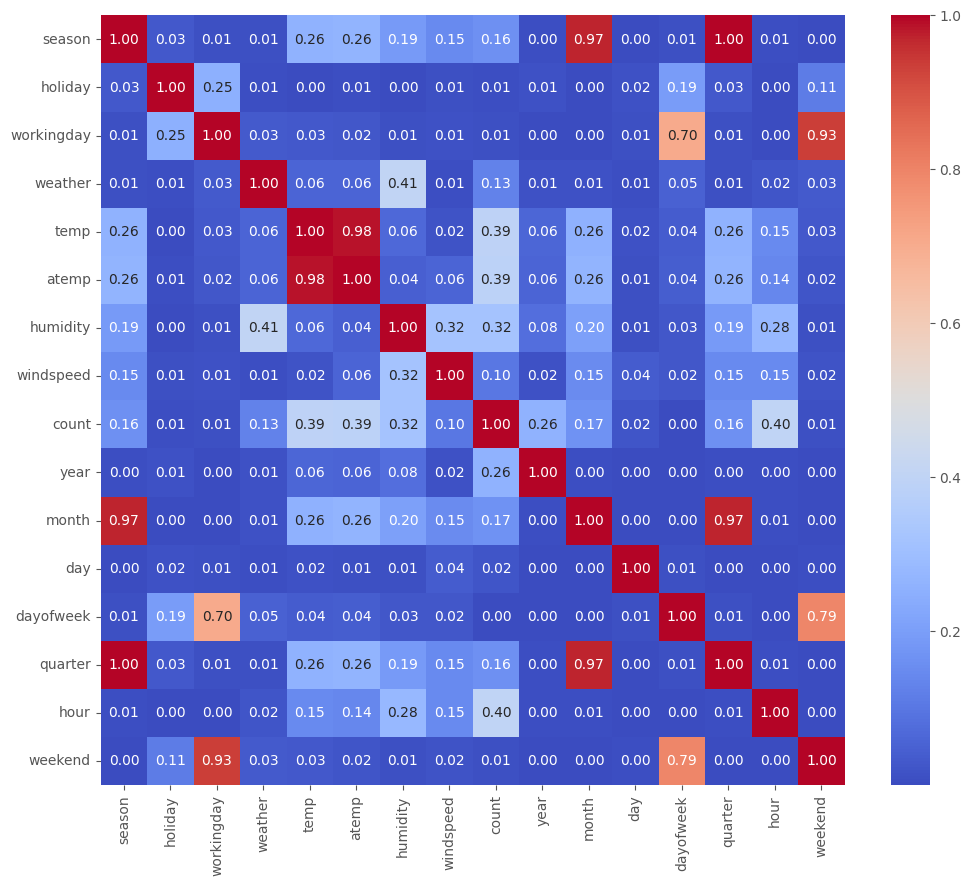

In [25]:
plt.figure(figsize=(12,10))

sns.heatmap(abs(pre_train.corr()), annot=True, fmt=".2f", cmap='coolwarm')

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(n_components=1, random_state=args.SEED)

pca_temp = pca.fit_transform(pre_train[['temp', 'atemp']])
pre_train = pre_train.drop(['temp', 'atemp'], axis=1)
pre_train['pca_temp'] = pca_temp

pca_temp = pca.transform(pre_test[['temp', 'atemp']])
pre_test = pre_test.drop(['temp', 'atemp'], axis=1)
pre_test['pca_temp'] = pca_temp

In [28]:
pca = PCA(n_components=1, random_state=args.SEED)

pca_month = pca.fit_transform(pre_train[['month', 'quarter', 'season']])
pre_train = pre_train.drop(['month', 'quarter', 'season'], axis=1)
pre_train['pca_month'] = pca_month

pca_month = pca.transform(pre_test[['month', 'quarter', 'season']])
pre_test = pre_test.drop(['month', 'quarter', 'season'], axis=1)
pre_test['pca_month'] = pca_month

In [29]:
pca = PCA(n_components=1, random_state=args.SEED)

pca_workingday = pca.fit_transform(pre_train[['workingday', 'dayofweek', 'weekend']])
pre_train = pre_train.drop(['workingday', 'dayofweek', 'weekend'], axis=1)
pre_train['pca_workingday'] = pca_workingday

pca_workingday = pca.transform(pre_test[['workingday', 'dayofweek', 'weekend']])
pre_test = pre_test.drop(['workingday', 'dayofweek', 'weekend'], axis=1)
pre_test['pca_workingday'] = pca_workingday

<Axes: >

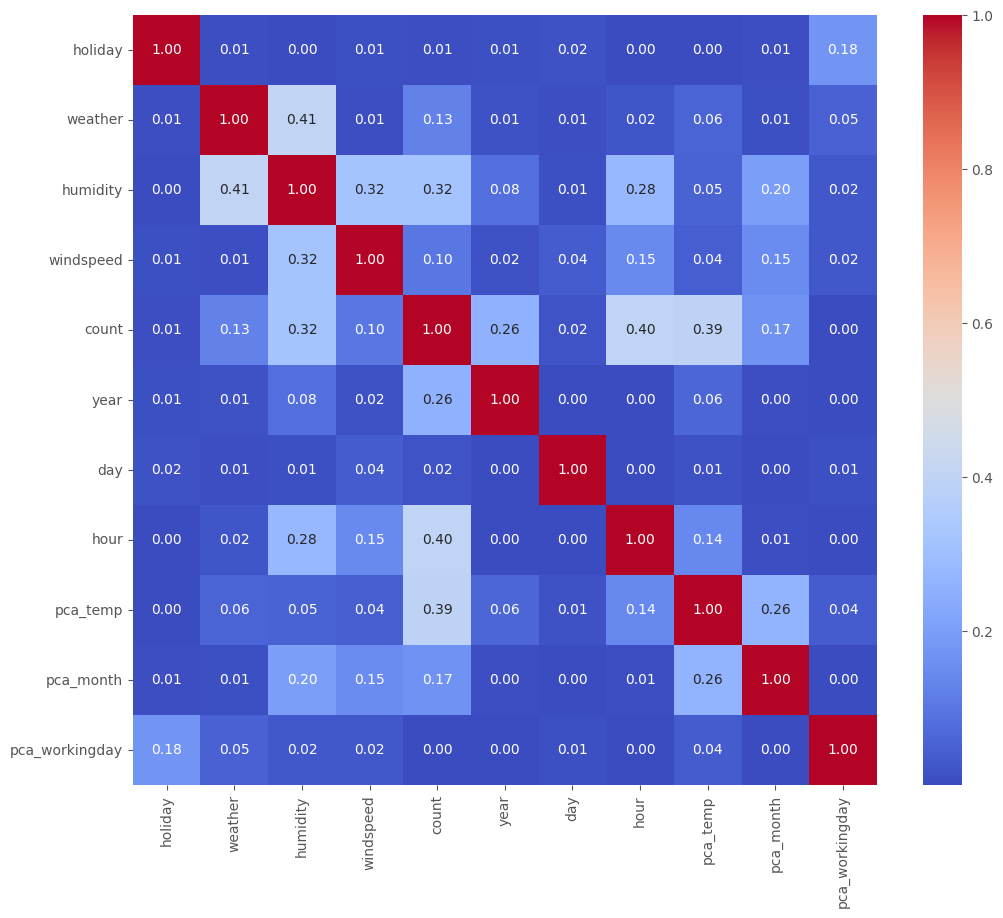

In [30]:
plt.figure(figsize=(12,10))

sns.heatmap(abs(pre_train.corr()), annot=True, fmt=".2f", cmap='coolwarm')

## windspeed
- windspeed의 0값 처리

<Axes: xlabel='windspeed', ylabel='count'>

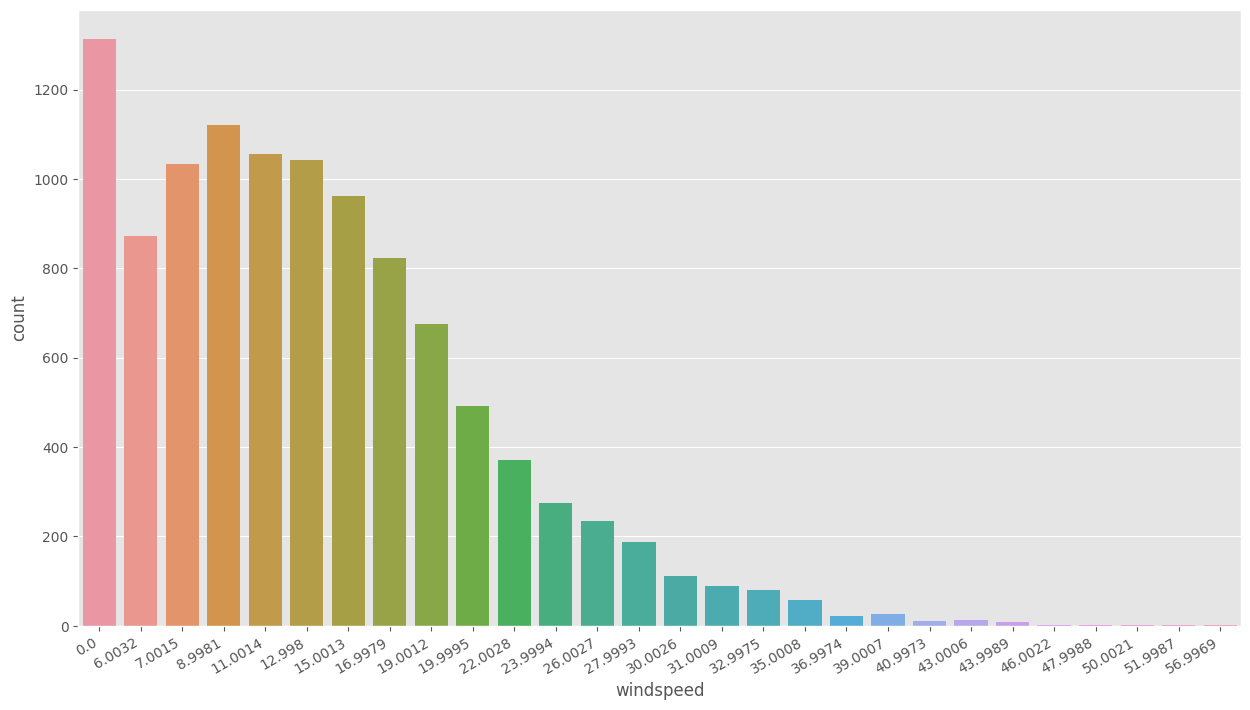

In [31]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=30, ha='right')
sns.countplot(data=pre_train, x='windspeed')

In [32]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(p_train, p_test):
    print(f'before: {p_train.shape} / {p_test.shape}')

    train_wind0 = p_train.loc[p_train['windspeed'] == 0]
    train_wind_not0 = p_train.loc[p_train['windspeed'] != 0]
    test_wind0 = p_test.loc[p_test['windspeed'] == 0]
    test_wind_not0 = p_test.loc[p_test['windspeed'] != 0]

    wind_cols = list(abs(p_train.corr())['windspeed'].sort_values().index)
    wind_cols.remove('count')
    wind_cols.remove('windspeed')
    print(f'len(wind_cols): {len(wind_cols)}')

    # training
    wind_rfc = RandomForestClassifier(random_state=args.SEED)
    train_wind_not0['windspeed'] = train_wind_not0['windspeed'].astype('str')
    wind_rfc.fit(train_wind_not0[wind_cols], train_wind_not0['windspeed'])
    score = wind_rfc.score(train_wind_not0[wind_cols], train_wind_not0['windspeed'])
    print(f'score: {score}')

    # predict
    train_wind0['windspeed'] = wind_rfc.predict(train_wind0[wind_cols])
    test_wind0['windspeed'] = wind_rfc.predict(test_wind0[wind_cols])

    # concat
    train = train_wind_not0.append(train_wind0).sort_values(by=['datetime'])
    train['windspeed'] = train['windspeed'].astype('float')
    train.reset_index(drop=True, inplace=True)
    test = test_wind_not0.append(test_wind0).sort_values(by=['datetime'])
    test['windspeed'] = test['windspeed'].astype('float')
    test.reset_index(drop=True, inplace=True)

    print(f'after: {train.shape} / {test.shape}')
    return train, test

In [33]:
pre_train, pre_test = predict_windspeed(pre_train, pre_test)

before: (10886, 12) / (6493, 11)
len(wind_cols): 9
score: 1.0
after: (10886, 12) / (6493, 11)


<Axes: xlabel='windspeed', ylabel='count'>

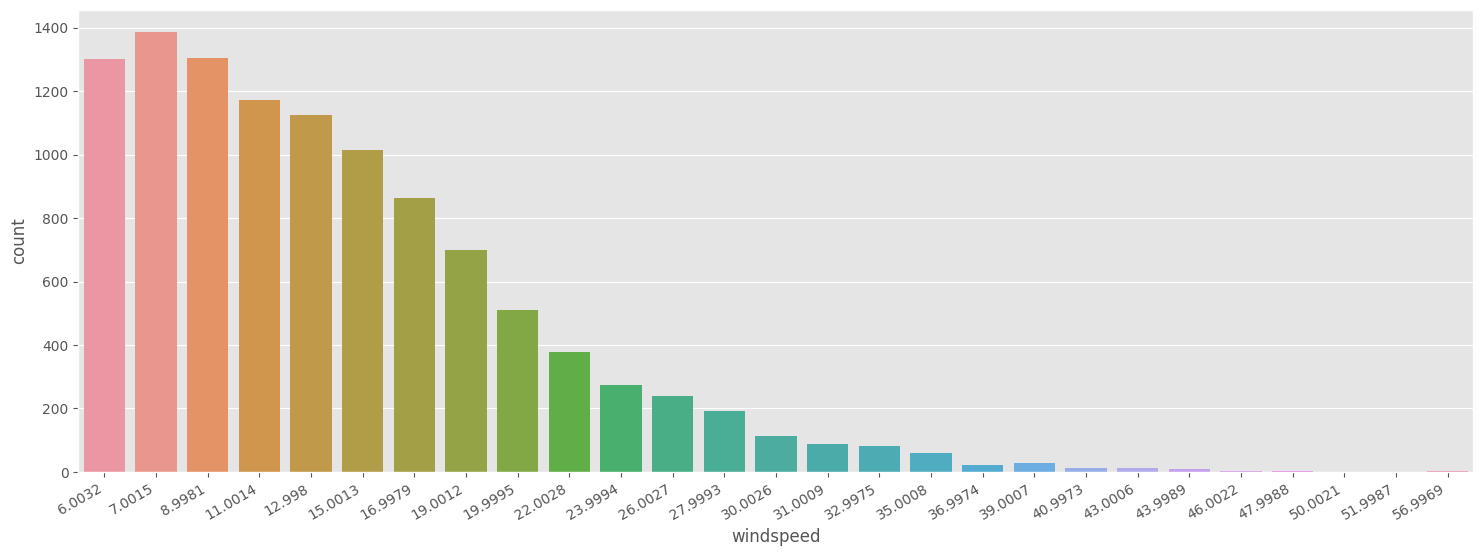

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax)
plt.xticks(rotation=30, ha='right')
sns.countplot(data=pre_train, x='windspeed', ax=ax)

# Feature Selection

In [35]:
pre_train.describe()

,holiday,weather,humidity,windspeed,count,year,day,hour,pca_temp,pca_month,pca_workingday
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,1.088600e+04,1.088600e+04,1.088600e+04
mean,0.028569,1.418427,61.886460,13.874775,191.574132,2011.501929,9.992559,11.541613,-3.341888e-16,-6.683775e-16,-2.167005e-16
std,0.166599,0.633839,19.245033,7.033159,181.144454,0.500019,5.476608,6.915838,1.146898e+01,3.773440e+00,2.065391e+00
min,0.000000,1.000000,0.000000,6.003200,1.000000,2011.000000,1.000000,0.000000,-2.899539e+01,-5.862735e+00,-3.027260e+00
25%,0.000000,1.000000,47.000000,8.998100,42.000000,2011.000000,5.000000,6.000000,-8.963992e+00,-4.038656e+00,-2.057873e+00
50%,0.000000,1.000000,62.000000,12.998000,145.000000,2012.000000,10.000000,12.000000,-6.128708e-01,-7.225650e-01,-1.190992e-01
75%,0.000000,2.000000,77.000000,16.997900,284.000000,2012.000000,15.000000,18.000000,9.403582e+00,2.593526e+00,2.166629e+00
max,1.000000,4.000000,100.000000,56.996900,977.000000,2012.000000,19.000000,23.000000,2.999261e+01,5.909617e+00,3.136016e+00


## drop cols

In [36]:
print(pre_train['day'].unique())
print(pre_test['day'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29 30 31]


In [37]:
drop_cols = ['datetime', 'day']

print(f'before: {pre_train.shape} / {pre_test.shape}')
pre_train = pre_train.drop(drop_cols, axis=1)
pre_test = pre_test.drop(drop_cols, axis=1)
print(f'after: {pre_train.shape} / {pre_test.shape}')

before: (10886, 12) / (6493, 11)
after: (10886, 10) / (6493, 9)


## convert categorical

In [38]:
categorical_cols = [
    'holiday', 'weather', 'year', 'hour'
]

for col in categorical_cols:
    pre_train[col] = pre_train[col].astype('category')
    pre_test[col] = pre_test[col].astype('category')

pre_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   holiday         10886 non-null  category
 1   weather         10886 non-null  category
 2   humidity        10886 non-null  int64   
 3   windspeed       10886 non-null  float64 
 4   count           10886 non-null  int64   
 5   year            10886 non-null  category
 6   hour            10886 non-null  category
 7   pca_temp        10886 non-null  float64 
 8   pca_month       10886 non-null  float64 
 9   pca_workingday  10886 non-null  float64 
dtypes: category(4), float64(4), int64(2)
memory usage: 554.1 KB


In [39]:
pre_train.shape, pre_test.shape

((10886, 10), (6493, 9))

# base model

In [40]:
print(f'{pre_train.shape} / {pre_test.shape}')

train = pre_train.copy()
test = pre_test.copy()

train.shape, test.shape

(10886, 10) / (6493, 9)


((10886, 10), (6493, 9))

## split data

In [41]:
y_train = train[args.target_col]
x_train = train.drop([args.target_col], axis=1)

x_train.shape, y_train.shape

((10886, 9), (10886,))

In [42]:
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x_train, y_train, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((8164, 9), (2722, 9), (8164,), (2722,))

## Pipeline

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler

In [44]:
from lightgbm import LGBMRegressor, plot_importance

hp = {
    "random_state" : args.SEED
}

In [45]:
base_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LGBMRegressor(**hp))
])

base_pipe.fit(x_tr, y_tr)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 8164, number of used features: 9
[LightGBM] [Info] Start training from score 191.339784


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LGBMRegressor(random_state=42))])

In [46]:
tr_score = base_pipe.score(x_tr, y_tr)
te_score = base_pipe.score(x_te, y_te)

print(f'{tr_score} / {te_score}')

0.9664684136713371 / 0.9557019402622107


### prediction

In [47]:
pre_tr = base_pipe.predict(x_tr)
pre_te = base_pipe.predict(x_te)

tr_rmsle = rmsle(y_tr, pre_tr)
te_rmsle = rmsle(y_te, pre_te)
print(f'{tr_rmsle} / {te_rmsle}')

0.43474838198991894 / 0.46577475649374556


### plot_importance

In [48]:
x_tr.columns

Index(['holiday', 'weather', 'humidity', 'windspeed', 'year', 'hour',
       'pca_temp', 'pca_month', 'pca_workingday'],
      dtype='object')

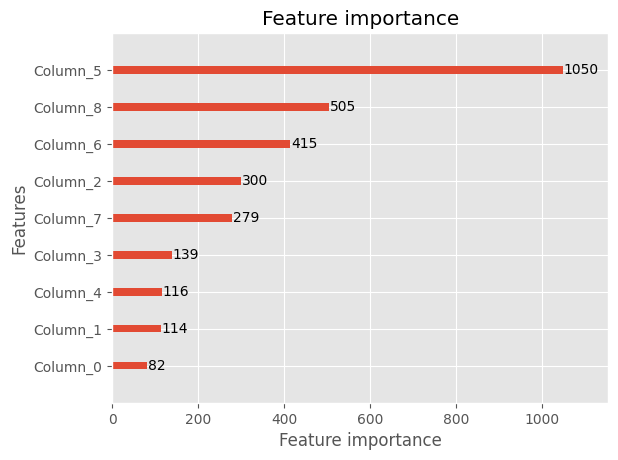

In [49]:
import matplotlib.pyplot as plt
plot_importance(base_pipe['regressor'])
plt.show()

### cross validation

In [50]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [51]:
# 교차 검증
kf = KFold(n_splits=5, shuffle=True, random_state=args.SEED)

scores = cross_val_score(base_pipe, x_train, y_train, scoring=rmsle_scorer, cv=kf)
cv_score = scores.mean()
cv_score

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 9
[LightGBM] [Info] Start training from score 191.584750
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 8709, number of used features: 9
[LightGBM] [Info] Start training from score 192.251120
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is no

0.4429474067651823

### create result

In [52]:
base_result = {
    'pip':'base_pipe',
    'HPO':'None',
    'best_rmsle':te_rmsle,
    'best_score':cv_score
}

base_result

{'pip': 'base_pipe',
 'HPO': 'None',
 'best_rmsle': 0.46577475649374556,
 'best_score': 0.4429474067651823}

# ModelV1
- https://smecsm.tistory.com/133
- https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [53]:
print(f'{pre_train.shape} / {pre_test.shape}')

train = pre_train.copy()
test = pre_test.copy()

train.shape, test.shape

(10886, 10) / (6493, 9)


((10886, 10), (6493, 9))

## split data

In [54]:
y_train = train[args.target_col]
x_train = train.drop([args.target_col], axis=1)

x_train.shape, y_train.shape

((10886, 9), (10886,))

In [55]:
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x_train, y_train, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((8164, 9), (2722, 9), (8164,), (2722,))

## Pipeline

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler

In [57]:
from lightgbm import LGBMRegressor, plot_importance

### RandomizedSearchCV

In [58]:
from sklearn.model_selection import RandomizedSearchCV

- max_depth
  - Tree 깊이를 명확하게 제한하기 위해 max_depth 값을 설정할 수도 있습니다.
- num_leaves
  -  Tree 모델의 복잡성을 컨트롤하는 주요 파라미터입니다. 이상적으로 num_leaves 값은 2 ^ (max_depth) 값보다 적거나 같아야 합니다. 이것보다 많은 값은 과적합을 유발할 것입니다.
- min_data_in_leaf
  - 큰 값으로 세팅하는 것은 Tree가 너무 깊게 확장되는 것을 막을 수 있지만 under-fitting 언더 피팅이 발생할 수도 있습니다. 관행적으로, 수백 또는 수천 개로 정하는 것이 큰 데이터 세트에 충분합니다.

#### Experiment

- 1차시도

In [59]:
reset_seeds()

model = LGBMRegressor(random_state=args.SEED)
v1_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', model)
])


n_iter=50
hp={
    "regressor__max_depth" : np.linspace(1,15,8,dtype = int), # 깊이
    "regressor__criterion" : ["gini","entropy"], # 순수도 척도
    "regressor__n_estimators" : np.linspace(50,500,8, dtype = int), # 부스팅 단계수
    "regressor__learning_rate" : np.logspace(-5, -2, 5),
    "regressor__num_leaves" : np.linspace(2**1,2**15,20,dtype = int),
    "regressor__min_data_in_leaf" : np.linspace(10,200,8, dtype = int)
}


v1_rs=RandomizedSearchCV(v1_pipe, hp, scoring=rmsle_scorer, n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False)
v1_rs.fit(x_tr, y_tr)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 8164, number of used features: 9
[LightGBM] [Info] Start training from score 191.339784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regressor',
                                              LGBMRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__criterion': ['gini',
                                                                 'entropy'],
                                        'regressor__learning_rate': array([1.00000000e-05, 5.62341325e-05, 3.16227766e-04, 1.77827941e-03,
       1.0...
                                        'regressor__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15]),
                                        'regressor__min_data_in_leaf': array([ 10,  37,  64,  91, 118, 145, 172, 200]),
                                        'regressor__n_estimators': array([ 50, 114, 178, 242, 307, 371, 435, 500]),
                                        'regressor__num_leaves': array([    2,  1726,  3451,  5175,  6900,  8624, 10349, 12073, 13798,
       15522, 17247, 18971, 20696, 22420, 24145, 25869, 27594, 29318,
       31043, 32768])},
                   scoring=make_scorer(rmsle), verbose=False)

In [60]:
v1_rs.best_score_, v1_rs.score(x_te, y_te)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


(1.5713808395470772, 1.5592307480825216)

In [61]:
v1_rs.best_params_

{'regressor__num_leaves': 10349,
 'regressor__n_estimators': 50,
 'regressor__min_data_in_leaf': 200,
 'regressor__max_depth': 5,
 'regressor__learning_rate': 1e-05,
 'regressor__criterion': 'entropy'}

- 2차시도

In [69]:
reset_seeds()

model = LGBMRegressor(random_state=args.SEED)
v1_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', model)
])


n_iter=50
hp={
    "regressor__max_depth" : np.linspace(1,15,8,dtype = int), # 깊이
    "regressor__criterion" : ["gini","entropy"], # 순수도 척도
    "regressor__n_estimators" : np.linspace(10,300,8, dtype = int), # 부스팅 단계수
    "regressor__learning_rate" : np.logspace(-7, -2, 5),
    "regressor__num_leaves" : np.linspace(2**1,2**15,20,dtype = int),
    "regressor__min_data_in_leaf" : np.linspace(100,500,8, dtype = int)
}


v1_rs=RandomizedSearchCV(v1_pipe, hp, scoring=rmsle_scorer, n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False)
v1_rs.fit(x_tr, y_tr)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 8164, number of used features: 8
[LightGBM] [Info] Start training from score 191.339784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regressor',
                                              LGBMRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__criterion': ['gini',
                                                                 'entropy'],
                                        'regressor__learning_rate': array([1.00000000e-07, 1.77827941e-06, 3.16227766e-05, 5.62341325e-04,
       1.0...
                                        'regressor__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15]),
                                        'regressor__min_data_in_leaf': array([100, 157, 214, 271, 328, 385, 442, 500]),
                                        'regressor__n_estimators': array([ 10,  51,  92, 134, 175, 217, 258, 300]),
                                        'regressor__num_leaves': array([    2,  1726,  3451,  5175,  6900,  8624, 10349, 12073, 13798,
       15522, 17247, 18971, 20696, 22420, 24145, 25869, 27594, 29318,
       31043, 32768])},
                   scoring=make_scorer(rmsle), verbose=False)

In [70]:
v1_rs.best_score_, v1_rs.score(x_te, y_te)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


(1.571645659204153, 1.5594928262849754)

In [71]:
v1_rs.best_params_

{'regressor__num_leaves': 10349,
 'regressor__n_estimators': 10,
 'regressor__min_data_in_leaf': 500,
 'regressor__max_depth': 5,
 'regressor__learning_rate': 1e-07,
 'regressor__criterion': 'entropy'}

- 3차시도

In [72]:
reset_seeds()

model = LGBMRegressor(random_state=args.SEED)
v1_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', model)
])


n_iter=50
hp={
    "regressor__max_depth" : np.linspace(1,15,8,dtype = int), # 깊이
    "regressor__criterion" : ["gini","entropy"], # 순수도 척도
    "regressor__n_estimators" : np.linspace(5,100,8, dtype = int), # 부스팅 단계수
    "regressor__learning_rate" : np.logspace(-7, -2, 5),
    "regressor__num_leaves" : np.linspace(2**1,2**15,20,dtype = int),
    "regressor__min_data_in_leaf" : np.linspace(100,800,8, dtype = int)
}


v1_rs=RandomizedSearchCV(v1_pipe, hp, scoring=rmsle_scorer, n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False)
v1_rs.fit(x_tr, y_tr)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 8164, number of used features: 8
[LightGBM] [Info] Start training from score 191.339784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regressor',
                                              LGBMRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__criterion': ['gini',
                                                                 'entropy'],
                                        'regressor__learning_rate': array([1.00000000e-07, 1.77827941e-06, 3.16227766e-05, 5.62341325e-04,
       1.0...
                                        'regressor__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15]),
                                        'regressor__min_data_in_leaf': array([100, 200, 300, 400, 500, 600, 700, 800]),
                                        'regressor__n_estimators': array([  5,  18,  32,  45,  59,  72,  86, 100]),
                                        'regressor__num_leaves': array([    2,  1726,  3451,  5175,  6900,  8624, 10349, 12073, 13798,
       15522, 17247, 18971, 20696, 22420, 24145, 25869, 27594, 29318,
       31043, 32768])},
                   scoring=make_scorer(rmsle), verbose=False)

In [73]:
v1_rs.best_score_, v1_rs.score(x_te, y_te)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800


(1.5716459279596915, 1.5594930902844628)

In [74]:
v1_rs.best_params_

{'regressor__num_leaves': 10349,
 'regressor__n_estimators': 5,
 'regressor__min_data_in_leaf': 800,
 'regressor__max_depth': 5,
 'regressor__learning_rate': 1e-07,
 'regressor__criterion': 'entropy'}

### best model

In [75]:
hp = v1_rs.best_params_
hp['random_state'] = args.SEED
hp

{'regressor__num_leaves': 10349,
 'regressor__n_estimators': 5,
 'regressor__min_data_in_leaf': 800,
 'regressor__max_depth': 5,
 'regressor__learning_rate': 1e-07,
 'regressor__criterion': 'entropy',
 'random_state': 42}

In [76]:
reset_seeds()

v1_best = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LGBMRegressor(**hp))
])

v1_best.fit(x_train, y_train)

[LightGBM] [Warning] Unknown parameter: regressor__min_data_in_leaf
[LightGBM] [Warning] Unknown parameter: regressor__n_estimators
[LightGBM] [Warning] Unknown parameter: regressor__criterion
[LightGBM] [Warning] Unknown parameter: regressor__max_depth
[LightGBM] [Warning] Unknown parameter: regressor__learning_rate
[LightGBM] [Warning] Unknown parameter: regressor__num_leaves
[LightGBM] [Warning] Unknown parameter: regressor__min_data_in_leaf
[LightGBM] [Warning] Unknown parameter: regressor__n_estimators
[LightGBM] [Warning] Unknown parameter: regressor__criterion
[LightGBM] [Warning] Unknown parameter: regressor__max_depth
[LightGBM] [Warning] Unknown parameter: regressor__learning_rate
[LightGBM] [Warning] Unknown parameter: regressor__num_leaves
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 LGBMRegressor(random_state=42, regressor__criterion='entropy',
                               regressor__learning_rate=1e-07,
                               regressor__max_depth=5,
                               regressor__min_data_in_leaf=800,
                               regressor__n_estimators=5,
                               regressor__num_leaves=10349))])

In [77]:
v1_best_score = v1_best.score(x_train, y_train)

pre_x = v1_best.predict(x_train)
v1_best_rmsle = rmsle(y_train, pre_x)

print(f'{v1_best_score} / {v1_best_rmsle}')

[LightGBM] [Warning] Unknown parameter: regressor__min_data_in_leaf
[LightGBM] [Warning] Unknown parameter: regressor__n_estimators
[LightGBM] [Warning] Unknown parameter: regressor__criterion
[LightGBM] [Warning] Unknown parameter: regressor__max_depth
[LightGBM] [Warning] Unknown parameter: regressor__learning_rate
[LightGBM] [Warning] Unknown parameter: regressor__num_leaves
[LightGBM] [Warning] Unknown parameter: regressor__min_data_in_leaf
[LightGBM] [Warning] Unknown parameter: regressor__n_estimators
[LightGBM] [Warning] Unknown parameter: regressor__criterion
[LightGBM] [Warning] Unknown parameter: regressor__max_depth
[LightGBM] [Warning] Unknown parameter: regressor__learning_rate
[LightGBM] [Warning] Unknown parameter: regressor__num_leaves
0.965978021004188 / 0.41616851453327935


### result

In [78]:
v1_result = {
    'pip':'v1_best',
    'HPO':v1_rs.best_params_,
    'best_score':v1_best_score,
    'best_rmsle':v1_best_rmsle
}

v1_result

{'pip': 'v1_best',
 'HPO': {'regressor__num_leaves': 10349,
  'regressor__n_estimators': 5,
  'regressor__min_data_in_leaf': 800,
  'regressor__max_depth': 5,
  'regressor__learning_rate': 1e-07,
  'regressor__criterion': 'entropy',
  'random_state': 42},
 'best_score': 0.965978021004188,
 'best_rmsle': 0.41616851453327935}

# ModelV2

In [79]:
print(f'{pre_train.shape} / {pre_test.shape}')

train = pre_train.copy()
test = pre_test.copy()

train.shape, test.shape

(10886, 10) / (6493, 9)


((10886, 10), (6493, 9))

## split data

In [80]:
y_train = train[args.target_col]
x_train = train.drop([args.target_col], axis=1)

x_train.shape, y_train.shape

((10886, 9), (10886,))

## BayesianSearch

In [81]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.7 MB/s eta 0:00:00


In [82]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

from sklearn.model_selection import cross_val_score

In [83]:
class Objective:
    def __init__(self,x_train,y_train,seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds=2 # 학습시간을 줄이기 위해 2로 하였다. 일반적으로는 5
        self.cv = KFold(n_splits=num_folds,shuffle=True,random_state=self.seed)
    def __call__(self,trial):
        hp = {
            "max_depth" : trial.suggest_int("max_depth",2,5),
            "min_samples_split" : trial.suggest_int("min_samples_split",2,5),
            "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",5,10),
            "n_estimators" : trial.suggest_int("n_estimators",10,500,50),
            "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
        }
        model = LGBMRegressor(random_state=self.seed,**hp)
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv , scoring=rmsle_scorer)
        return np.mean(scores)

In [84]:
reset_seeds()

sampler = TPESampler(seed=args.SEED) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "minimize", # maximize or minimize
    sampler = sampler
)
objective = Objective(x_train, y_train, args.SEED)
study.optimize(objective,n_trials=50)

print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [85]:
optuna.visualization.plot_optimization_history(study)

In [86]:
optuna.visualization.plot_param_importances(study)

### best model

In [90]:
study.best_params

{'max_depth': 5,
 'min_samples_split': 4,
 'criterion': 'gini',
 'max_leaf_nodes': 8,
 'n_estimators': 260,
 'learning_rate': 0.02092268233501705}

In [87]:
reset_seeds()

v2_best = LGBMRegressor(random_state=args.SEED, **study.best_params)
v2_best.fit(x_train, y_train)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the tra

LGBMRegressor(criterion='gini', learning_rate=0.02092268233501705, max_depth=5,
              max_leaf_nodes=8, min_samples_split=4, n_estimators=260,
              random_state=42)

In [88]:
reset_seeds()

v2_best_score = v2_best.score(x_train, y_train)

pre_x = v2_best.predict(x_train)
v2_best_rmsle = rmsle(y_train, pre_x)

print(f'{v2_best_score} / {v2_best_rmsle}')

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.9387800745200423 / 0.4454449045162818


### result

In [89]:
v2_result = {
    'pip':'v2_best',
    'HPO':study.best_params,
    'best_score':v2_best_score,
    'best_rmsle':v2_best_rmsle
}

v2_result

{'pip': 'v2_best',
 'HPO': {'max_depth': 5,
  'min_samples_split': 4,
  'criterion': 'gini',
  'max_leaf_nodes': 8,
  'n_estimators': 260,
  'learning_rate': 0.02092268233501705},
 'best_score': 0.9387800745200423,
 'best_rmsle': 0.4454449045162818}

# 결과 비교

In [91]:
df_result = pd.DataFrame([base_result, v1_result, v2_result])

df_result.sort_values(by=['best_rmsle', 'best_score'])

,pip,HPO,best_rmsle,best_score
1,v1_best,"{'regressor__num_leaves': 10349, 'regressor__n...",0.416169,0.965978
2,v2_best,"{'max_depth': 5, 'min_samples_split': 4, 'crit...",0.445445,0.938780
0,base_pipe,None,0.465775,0.442947


# Submit

In [92]:
test = pre_test.copy()

test.shape

(6493, 9)

In [93]:
test_predict = v2_best.predict(test)

test_predict.shape

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=8 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


(6493,)

In [94]:
submission = pd.read_csv(args.submission_path)

print(submission.shape)
submission.head(3)

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0


In [95]:
submission['count'] = test_predict

print(submission.shape)
submission.head(3)

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,6.162879
1,2011-01-20 01:00:00,2.335513
2,2011-01-20 02:00:00,0.184195


In [96]:
submission['count'].describe()

count    6493.000000
mean      191.282473
std       165.836657
min       -13.312618
25%        52.086388
50%       159.669707
75%       288.461111
max       821.214691
Name: count, dtype: float64

- count는 양수만 가능

In [97]:
submission['count'] = submission['count'].map(lambda x: x if x>1 else 1)

submission['count'].describe()

count    6493.000000
mean      191.320398
std       165.792480
min         1.000000
25%        52.086388
50%       159.669707
75%       288.461111
max       821.214691
Name: count, dtype: float64

In [98]:
args.submission_file
submission_score = v2_result['best_rmsle']
print(f'submission_score: {submission_score}')
submission.to_csv(args.submission_file.format(submission_score), index=False)

submission_score: 0.4454449045162818


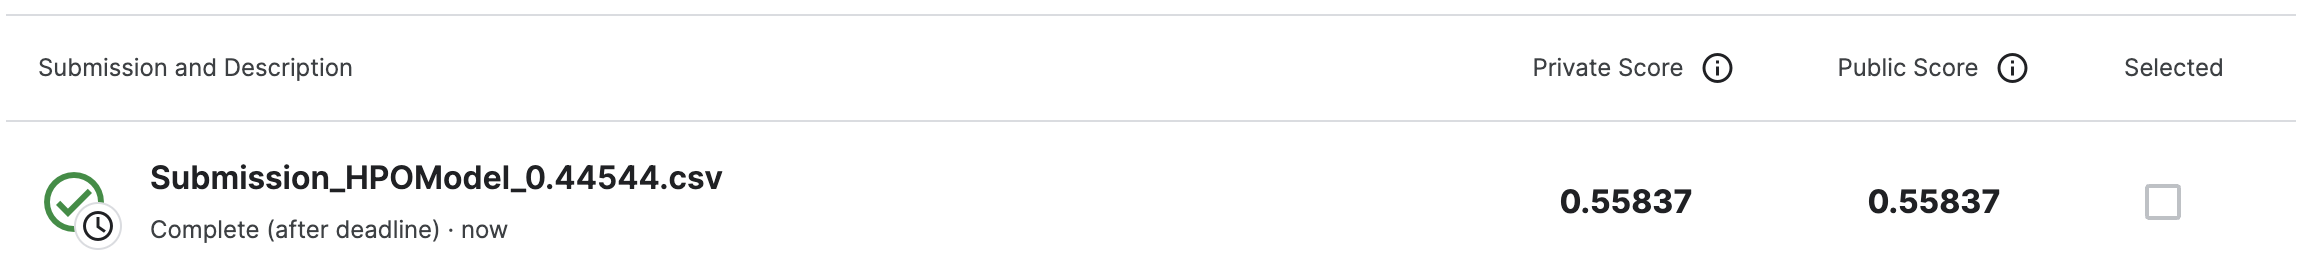